In [12]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from project_resources.import_utils import NotebookFinder
sys.meta_path.append(NotebookFinder())
from project_resources.cytochrome_P450 import fp_from_smiles, mol_predict_and_std, tanimoto, create_scatter_plot

In [13]:
models = ["linear", "KRR", "GB", "RF", "ANN"]
isozymes = ["3A4", "RLM", "HLC"]
data_splits = ["train", "test"]
splitters = ["rand", "scaff"]
rel_paths = {
    "3A4_source": r"project_resources/ChEMBL_3A4.csv",
    "3A4_sep": ";",
    "3A4": r"project_resources/3A4.csv",
    "3A4_train_scaff": r"project_resources/base_splits/scaffold_splitter/3A4_train.csv",
    "3A4_test_scaff": r"project_resources/base_splits/scaffold_splitter/3A4_test.csv",
    "3A4_train_rand": r"project_resources/base_splits/random/3A4_train.csv",
    "3A4_test_rand": r"project_resources/base_splits/random/3A4_test.csv",

    "RLM_source": r"project_resources/AID_1508591_datatable_all.csv",
    "RLM_sep": ",",
    "RLM": r"project_resources/RLM.csv",
    "RLM_train_scaff": r"project_resources/base_splits/scaffold_splitter/RLM_train.csv",
    "RLM_test_scaff": r"project_resources/base_splits/scaffold_splitter/RLM_test.csv",
    "RLM_train_rand": r"project_resources/base_splits/random/RLM_train.csv",
    "RLM_test_rand": r"project_resources/base_splits/random/RLM_test.csv",

    "HLC_source": r"project_resources/AID_1508603_datatable_all.csv",
    "HLC_sep": ",",
    "HLC": r"project_resources/HLC.csv",
    "HLC_train_scaff": r"project_resources/base_splits/scaffold_splitter/HLC_train.csv",
    "HLC_test_scaff": r"project_resources/base_splits/scaffold_splitter/HLC_test.csv",
    "HLC_train_rand": r"project_resources/base_splits/random/HLC_train.csv",
    "HLC_test_rand": r"project_resources/base_splits/random/HLC_test.csv"
}
smiles = {}
halflives = {}
fingerprints = {}
tanimoto_sims = {}
y_test_avg_predictions = {}
stds = {}
rmsds = {}
best_models = {}

In [14]:
# load train-test
for splitter in splitters:
    print(splitter)
    smiles[splitter] = {}
    halflives[splitter] = {}
    for isozyme in isozymes:
        smiles[splitter][isozyme] = {}
        halflives[splitter][isozyme] = {}

        for data_split in data_splits:
            # load smiles
            split_df = pd.read_csv(rel_paths[f"{isozyme}_{data_split}_{splitter}"])
            split_smi = np.array(split_df["smiles"])
            smiles[splitter][isozyme][data_split] = split_smi

            # load half-life
            split_df = pd.read_csv(rel_paths[f"{isozyme}_{data_split}_{splitter}"])
            split_halflife = np.array(split_df["half-life"])
            halflives[splitter][isozyme][data_split] = split_halflife

        print(f"""{isozyme}
    x_train: {smiles[splitter][isozyme]["train"][0]}
    x_test: {smiles[splitter][isozyme]["test"][0]}
    y_train: {halflives[splitter][isozyme]["train"][:3]}
    y_test: {halflives[splitter][isozyme]["test"][:3]}
    """)

rand
3A4
    x_train: CC(C)(O)c1cc(F)c2c(c1)C(=O)N(Cc1ccc(Cl)cn1)[C@@]2(OCC1(O)CC1)c1ccc(Cl)cc1
    x_test: Cc1ncsc1-c1ccc([C@H](CC(=O)NCCCCCCNC(=O)COc2c(-c3csc(N4CCOCC4)n3)ccc(F)c2F)NC(=O)[C@@H]2C[C@@H](O)CN2C(=O)[C@@H](NC(=O)C2(F)CC2)C(C)(C)C)cc1
    y_train: [6.   0.02 0.5 ]
    y_test: [0.3767  0.3333  0.01433]
    
RLM
    x_train: O=c1cc(N2CCOCC2)oc2c1ccc1ccccc12
    x_test: Cc1ccc(OCCn2c(CCNC(=O)N3CCCCC3)nc3ccccc32)cc1
    y_train: [30.    4.4  26.58]
    y_test: [ 1.7  1.7 30. ]
    
HLC
    x_train: N#Cc1ccc(CN2CCC(N3CCNC3=O)CC2)cc1
    x_test: c1ccc(Nc2ncc(-c3cncnc3)c3c2OCC3)cc1
    y_train: [93.2 21.  50.8]
    y_test: [120.  111.9  57.4]
    
scaff
3A4
    x_train: COc1cccc([C@@H](CO)NC(=O)[C@@H](C)N2Cc3ccc(-c4nc(NC5CCOCC5)ncc4Cl)cc3C2=O)c1
    x_test: O=C1CCC(N2C(=O)c3cccc(NCCOCCOCCNC(=O)c4ccc5c(c4)nc(Nc4cccc(Cl)c4)c4ccncc45)c3C2=O)C(=O)N1
    y_train: [0.09167 0.08333 0.8167 ]
    y_test: [0.2433 0.055  0.2667]
    
RLM
    x_train: CS(=O)(=O)c1ccccc1-c1csc(N2CCC(C(N)=O)C

In [15]:
# convert smiles from every isozyme and split to Morgan fingerprint as numpy array
for splitter in splitters:
    fingerprints[splitter] = {}
    for isozyme in isozymes:
        fingerprints[splitter][isozyme] = {}
        for data_split in data_splits:
            fps = fp_from_smiles(smiles[splitter][isozyme][data_split])
            fingerprints[splitter][isozyme][data_split] = np.array(fps)
            print(splitter, isozyme, data_split)
            print(fps[0])
        print("\n")

rand 3A4 train
[1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0
 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 1 0 0 0 1 1 1 0]
rand 3A4 test
[1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1 1
 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0
 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1
 1 1 0 0 0 1 0 1 1 1 1 1 1]


rand RLM train
[0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 1 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1
 1 0 0 1 0 0 0 0 0 1 0 1 0]
rand RLM test
[1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 

In [16]:
for splitter in splitters:
    y_test_avg_predictions[splitter] = {}
    stds[splitter] = {}
    rmsds[splitter] = {}
    for isozyme in isozymes:
        x_train = fingerprints[splitter][isozyme]["train"]
        y_train = np.log(halflives[splitter][isozyme]["train"])  # natural log half-lives -> values are less spread out
        x_test = fingerprints[splitter][isozyme]["test"]
        y_test = np.log(halflives[splitter][isozyme]["test"])
        print(splitter, isozyme)
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        y_test_avg_predict, std, rmsd = mol_predict_and_std(models, x_train, x_test, y_train, y_test)
        y_test_avg_predictions[splitter][isozyme] = y_test_avg_predict
        stds[splitter][isozyme] = std
        rmsds[splitter][isozyme] = rmsd
        print(f"     root-mean-square deviations: {rmsds[splitter][isozyme]}\n")

rand 3A4
(56, 124) (56,) (14, 124) (14,)
     best linear hyperparams: ElasticNet(alpha=0.01)
     best linear hyperparams: ElasticNet(alpha=0.01, l1_ratio=0.9)
     best linear hyperparams: ElasticNet(alpha=0.01, l1_ratio=0.9)
     best KRR hyperparams: KernelRidge(alpha=1.623776739188721, gamma=4.832930238571752e-11)
     best KRR hyperparams: KernelRidge(alpha=2.9763514416313193, gamma=0.0011288378916846883)
     best KRR hyperparams: KernelRidge(alpha=0.8858667904100823, gamma=4.281332398719387e-08)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=20)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.05, n_estimators=400)
     best GB hyperparams: GradientBoostingRegressor(learning_rate=0.02, max_depth=2, n_estimators=400)
     best RF hyperparams: RandomForestRegressor(max_features='log2')
     best RF hyperparams: RandomForestRegressor(max_depth=10, max_features='log2')
     best RF hyperparams: RandomForestRegres

In [17]:
for splitter in splitters:
    print(splitter)
    best_models[splitter] = {}
    for isozyme in isozymes:
        isozyme_rmsds = list(rmsds[splitter][isozyme].values())
        lowest_rmsd = min(isozyme_rmsds)
        best_model_for_isozyme = list(rmsds[splitter][isozyme].keys())[list(rmsds[splitter][isozyme].values()).index(lowest_rmsd)]
        best_models[splitter][isozyme] = best_model_for_isozyme
        print(f"best model for {isozyme}: {best_model_for_isozyme} with rmsd {lowest_rmsd}")

rand
best model for 3A4: RF with rmsd 1.3359053496129945
best model for RLM: KRR with rmsd 0.8810554180543325
best model for HLC: RF with rmsd 0.5437129060247295
scaff
best model for 3A4: GB with rmsd 1.3093022634997191
best model for RLM: KRR with rmsd 1.3419088168023197
best model for HLC: linear with rmsd 1.294857818263465


In [18]:
for splitter in splitters:
    print(splitter)
    tanimoto_sims[splitter] = {}
    for isozyme in isozymes:
        tanimoto_similarities = tanimoto(fingerprints[splitter][isozyme]["test"], fingerprints[splitter][isozyme]["train"])
        tanimoto_sims[splitter][isozyme] = tanimoto_similarities
        median = round(np.median(tanimoto_similarities), 3)
        mean = round(np.mean(tanimoto_similarities), 3)
        print(f"length: {len(tanimoto_similarities)}, median: {median}, arithmetic mean: {mean}, ",
              tanimoto_sims[splitter][isozyme][:10])

rand
length: 14, median: 0.832, arithmetic mean: 0.718,  [0.81, 0.406, 0.569, 0.914, 0.568, 0.883, 0.857, 0.915, 0.919, 1.0]
length: 507, median: 0.75, arithmetic mean: 0.707,  [0.809, 1.0, 0.769, 0.635, 0.8, 0.517, 0.525, 0.754, 0.516, 0.974]
length: 38, median: 0.795, arithmetic mean: 0.745,  [0.833, 0.83, 0.463, 0.757, 0.806, 0.531, 0.725, 0.867, 0.742, 0.739]
scaff
length: 14, median: 0.621, arithmetic mean: 0.613,  [0.649, 0.62, 0.509, 0.81, 0.5, 0.828, 0.833, 0.368, 0.5, 0.623]
length: 507, median: 0.537, arithmetic mean: 0.589,  [0.508, 0.683, 0.574, 0.566, 0.531, 0.538, 0.974, 0.556, 0.87, 0.773]
length: 38, median: 0.591, arithmetic mean: 0.607,  [0.686, 0.653, 0.5, 0.531, 0.561, 0.586, 0.444, 0.422, 0.533, 0.511]


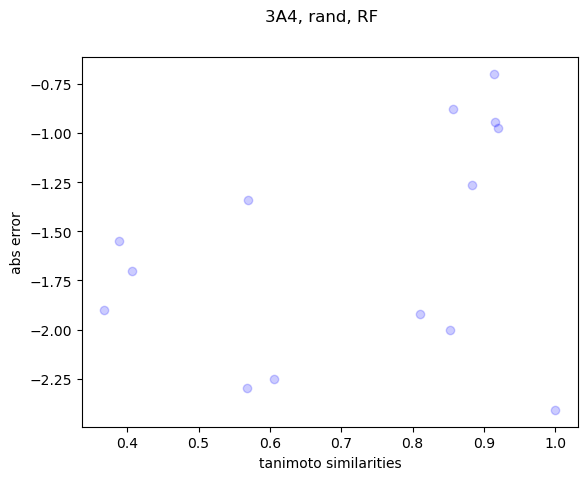

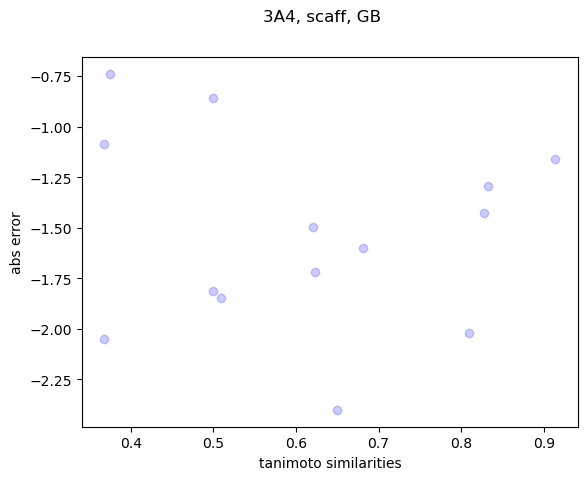

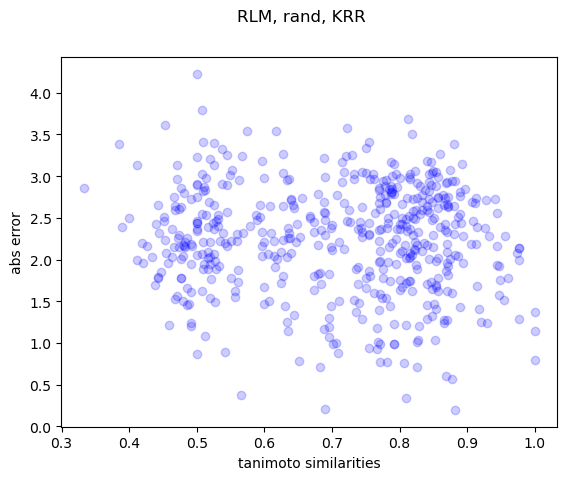

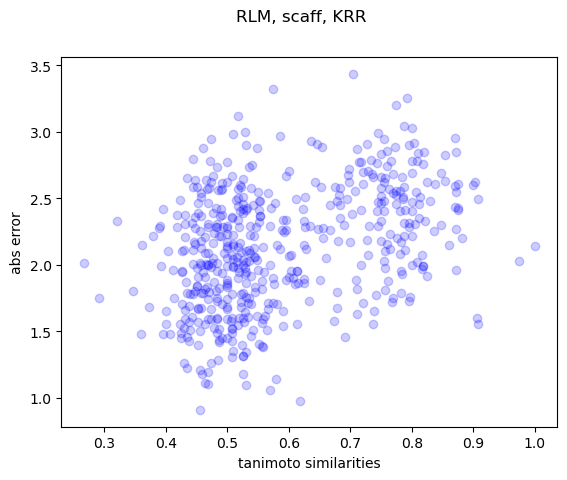

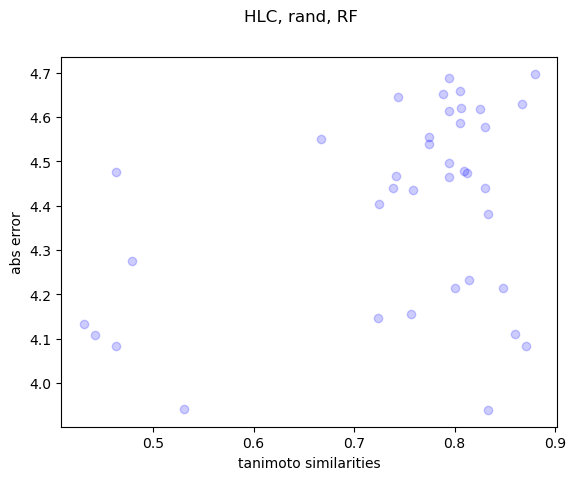

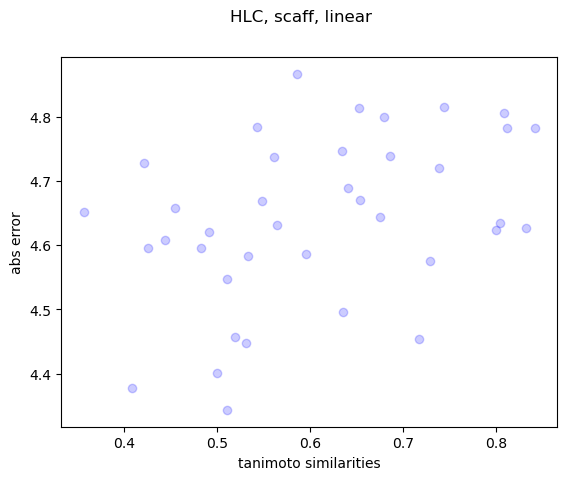

In [19]:
for isozyme in isozymes:
    for splitter in splitters:
        model = best_models[splitter][isozyme]
        create_scatter_plot(tanimoto_sims[splitter][isozyme], y_test_avg_predictions[splitter][isozyme][model],
                            f"{isozyme}, {splitter}, {model}", "tanimoto similarities", "abs error")

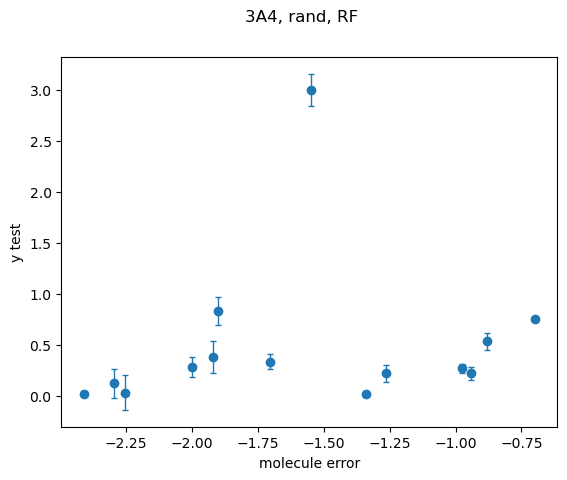

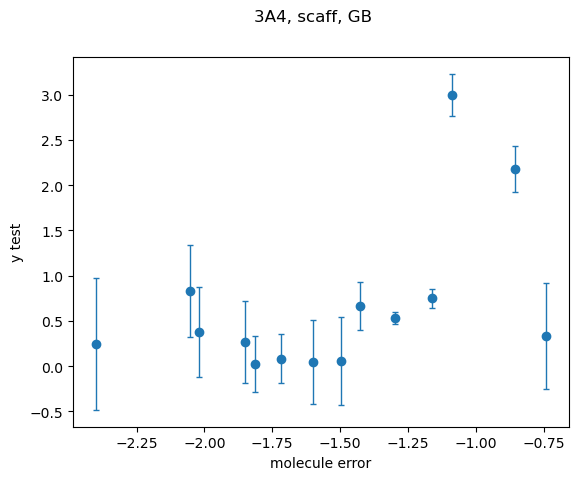

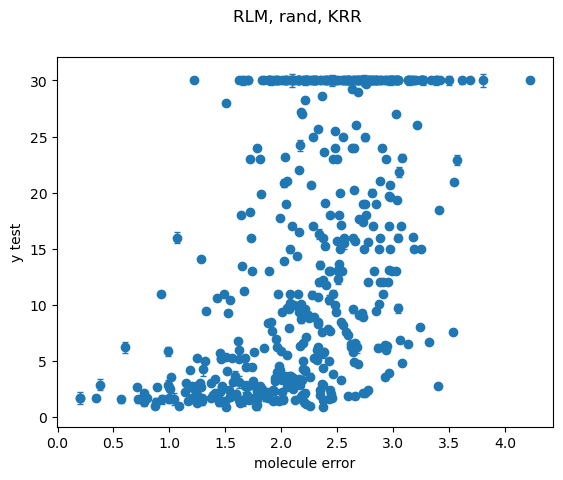

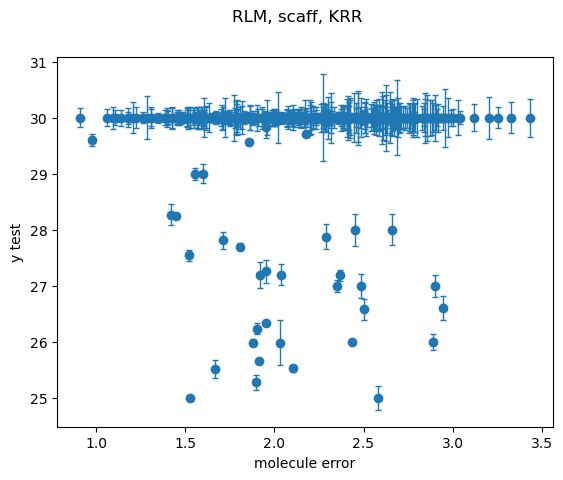

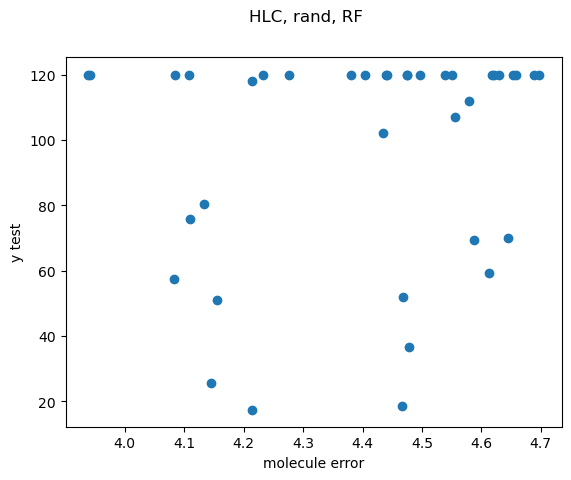

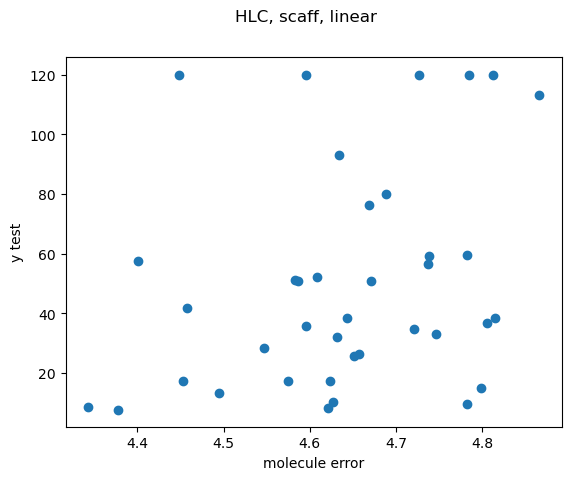

In [20]:
for isozyme in isozymes:
    for splitter in splitters:
        model = best_models[splitter][isozyme]
        plt.clf()
        plt.errorbar(y_test_avg_predictions[splitter][isozyme][model], halflives[splitter][isozyme]["test"],
                     yerr=stds[splitter][isozyme][model], linewidth=1, capsize=2, fmt='o')
        plt.xlabel('molecule error')
        plt.ylabel('y test')
        plt.suptitle(f"{isozyme}, {splitter}, {model}")
        plt.show()

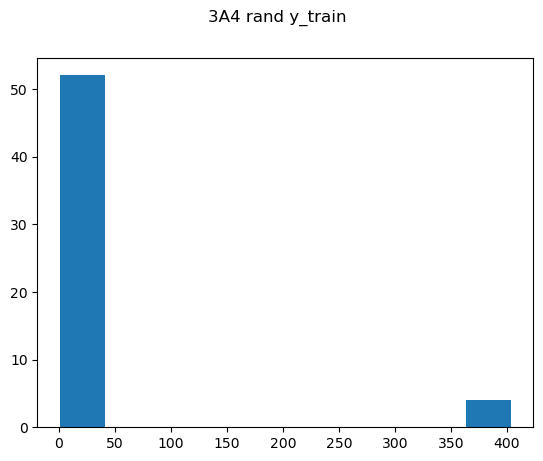

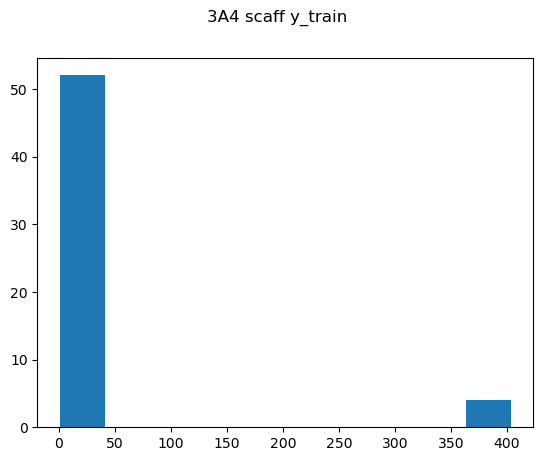

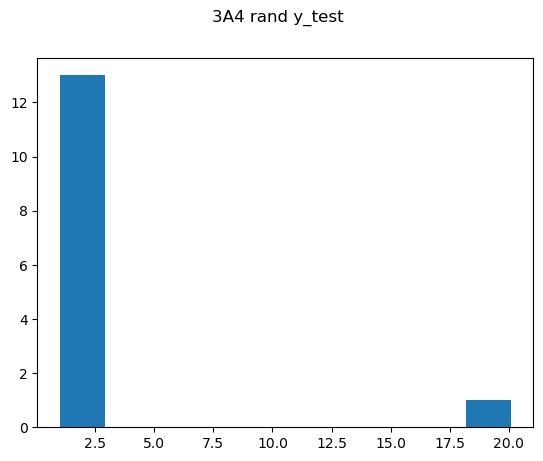

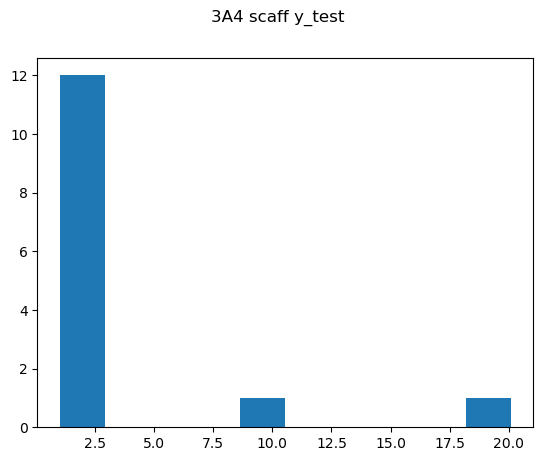

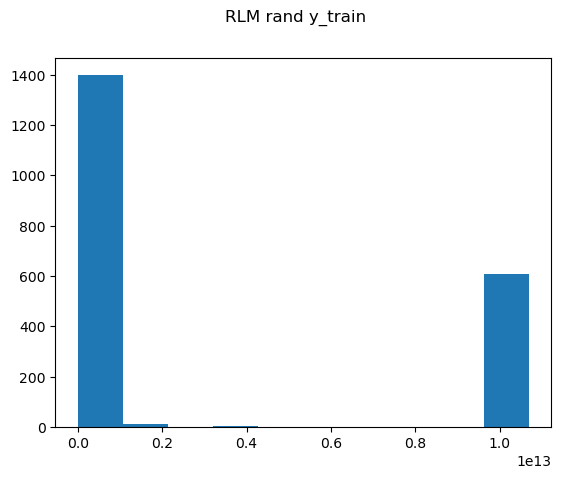

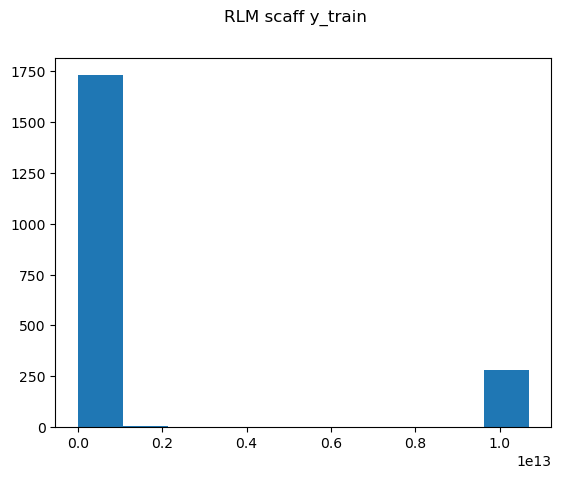

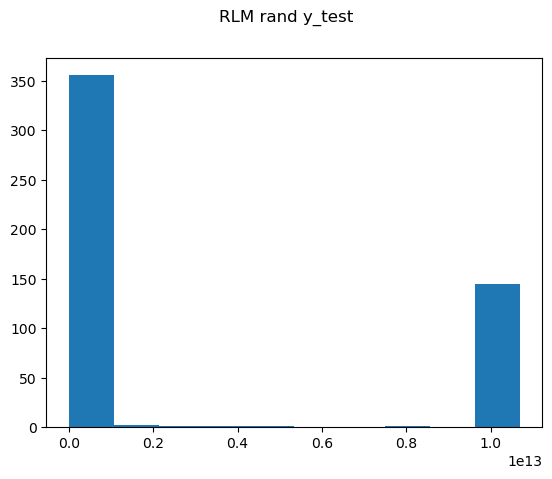

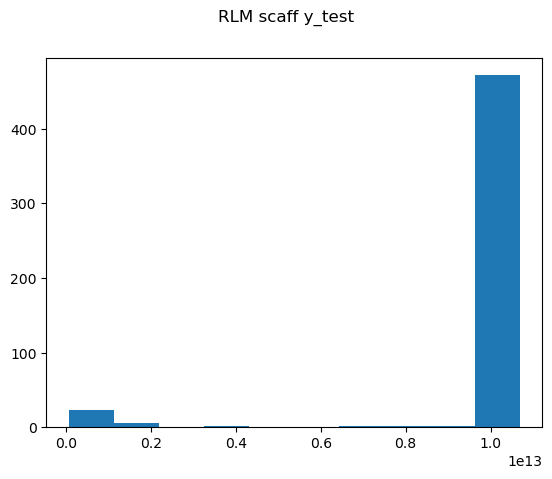

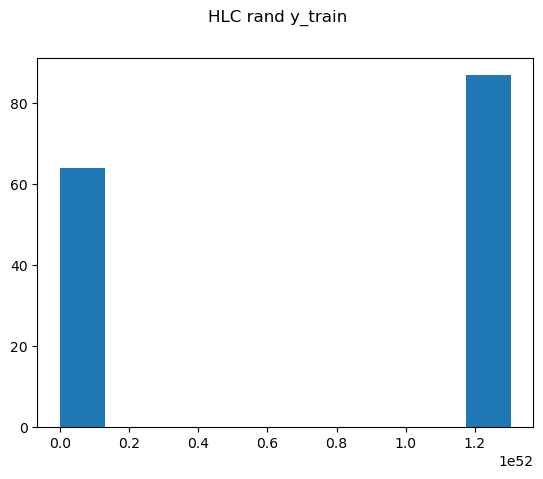

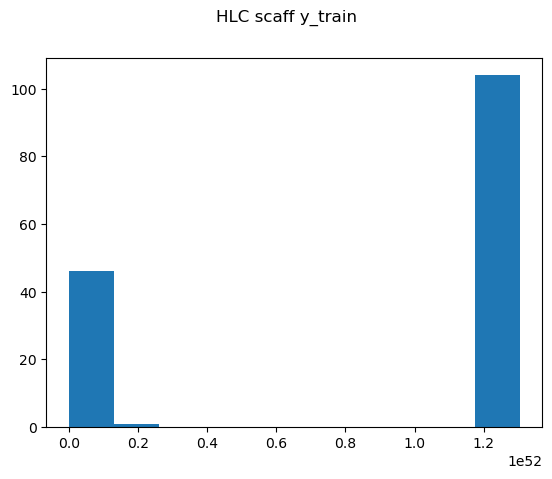

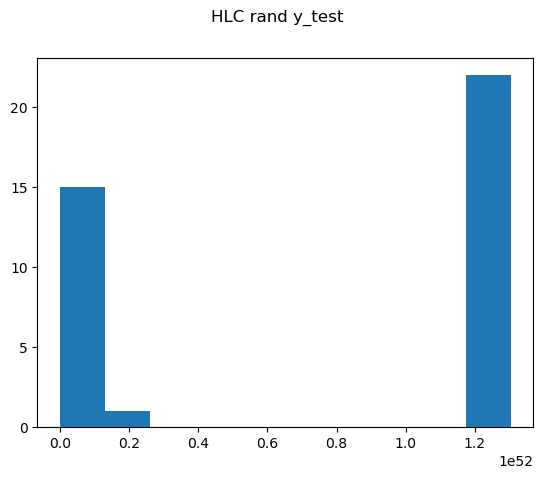

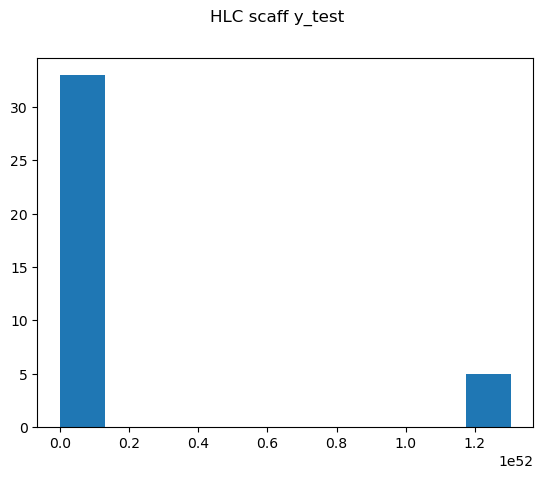

In [21]:
for isozyme in isozymes:
    for split in data_splits:
        for splitter in splitters:
            y_split = np.exp(halflives[splitter][isozyme][split])
            plt.hist(y_split)
            plt.suptitle(f"{isozyme} {splitter} y_{split}")
            plt.show()

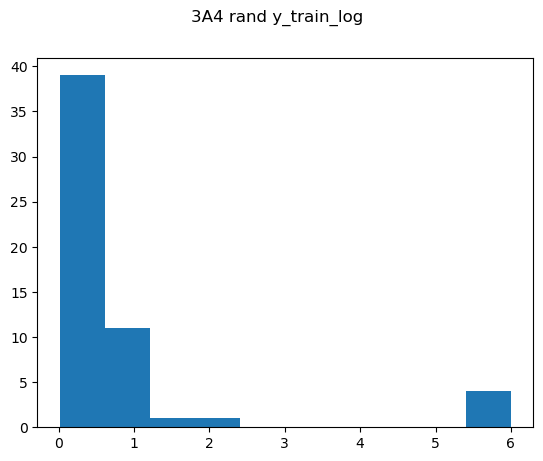

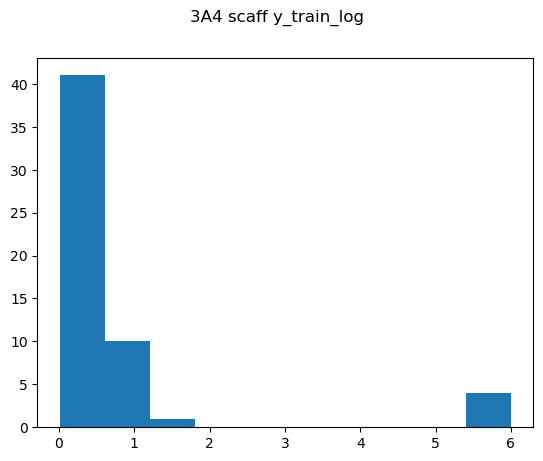

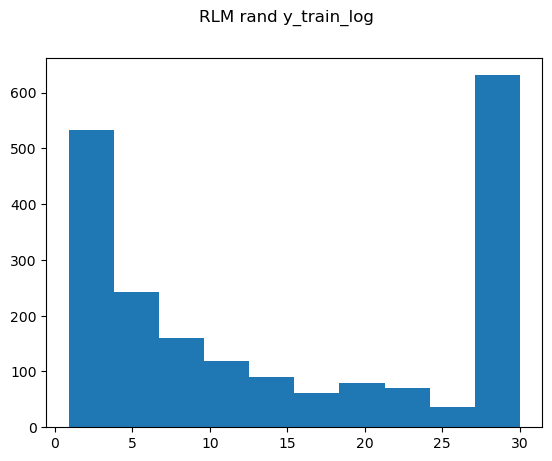

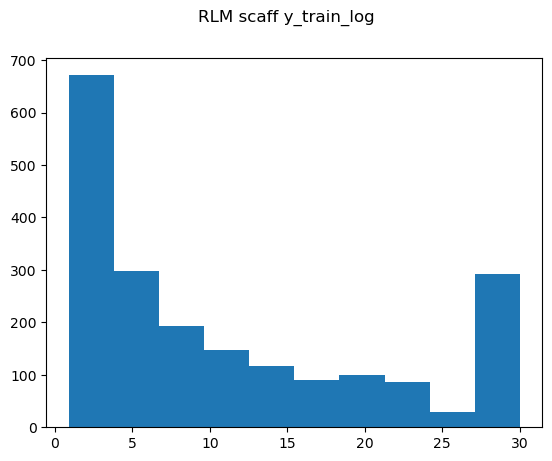

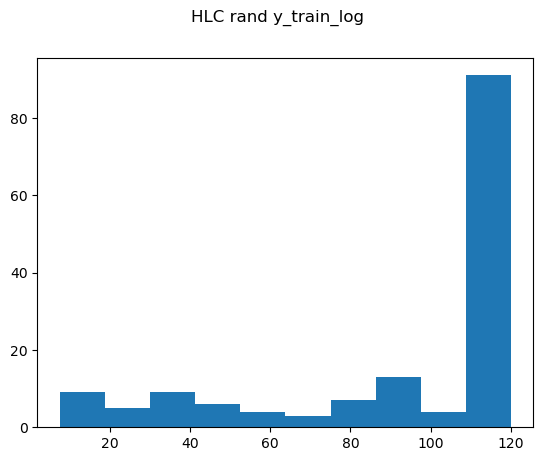

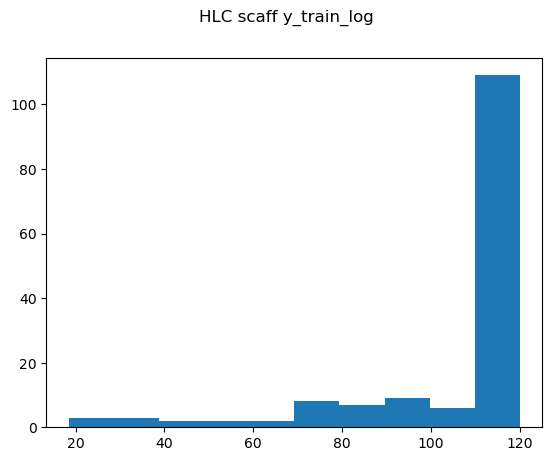

In [22]:
for isozyme in isozymes:
    for splitter in splitters:
        y_train_log = halflives[splitter][isozyme]["train"]
        plt.hist(y_train_log)
        plt.suptitle(f"{isozyme} {splitter} y_train_log")
        plt.show()